In [39]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from IPython.display import display


### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [81]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [59]:
X.shape

(8147, 16)

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [60]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

#what does ALL do

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


In [43]:
table_train.loc['All','All']

7332

Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

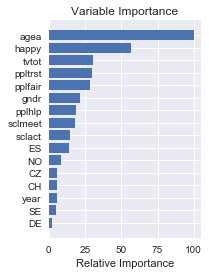

In [61]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

### Select Best Params to use with Grid Search

In [45]:
# X.describe()

In [46]:
# correlation_matrix = X.corr()
# display(correlation_matrix)

In [47]:
# sns.heatmap(X.corr())

In [48]:
# correlations = df.corr().loc[:,'partner'].abs().sort_values(ascending=False)
# correlations


In [62]:
from sklearn.model_selection import GridSearchCV


#adding to many param slows down run time, so I am going to select a few, and with those test out the other params
#i might be interested in 
param_search = [{'n_estimators': [300, 400, 500],
          'max_depth': [2,3,4],
          'loss': ['deviance','exponential'],
          'learning_rate': [0.05, .1, 0.2, 0.3],
#           'min_samples_split': [10, 20],
          'subsample':[.6, .8, 1]}]

# Initialize and fit the model.
grid_search = GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid=param_search, scoring = 'accuracy',cv=5)

grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [83]:
print(grid_search.best_params_)
print('\n')
print(grid_search.best_score_)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

OK, lets try using this params in our model. 
Question though. Do i need to fit again?

In [85]:
params = {'n_estimators': 300,
          'max_depth':2,
          'learning_rate': .05,
          'loss': 'exponential',
          'subsample':0.6}

# Initialize and fit the model. #Did i already instantiate and fit though? 
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04596290234588107
Percent Type II errors: 0.18726132024004363

Test set accuracy:
Percent Type I errors: 0.053987730061349694
Percent Type II errors: 0.19754601226993865


OK this is not what I was expecting. It could be that I didn't add enough options in my param grid search. 
However, including more would take a much longer time. I am going to adjust one at a time to see if that works. 

In [97]:
#learning rate changes
params = {'n_estimators': 300,
          'max_depth':2,
          'learning_rate': 1,
          'loss': 'exponential',
          'subsample':0.6}

# Initialize and fit the model. #Did i already instantiate and fit though? 
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.06833060556464812
Percent Type II errors: 0.14634478996181124

Test set accuracy:
Percent Type I errors: 0.12392638036809817
Percent Type II errors: 0.15828220858895706


In [118]:
#learning rate of 1 appears to give the lowest accuracy
#lets adjust the estimator size as well ---ends up that with a max_depth of 2, 300 works the best, lets adjust max_depth
#learning rate changes
params = {'n_estimators': 300,
          'max_depth':3,
          'learning_rate': 1,
          'loss': 'exponential',
          'subsample':0.6}

# Initialize and fit the model. #Did i already instantiate and fit though? 
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.06560283687943262
Percent Type II errors: 0.11074740861974905

Test set accuracy:
Percent Type I errors: 0.13987730061349693
Percent Type II errors: 0.15337423312883436


In [140]:
#the difference in accuracy for train and test set grows, which might be a sign of overfitting
# Let use 3 folds and change loss and play around with combos

params = {'n_estimators': 500,
          'max_depth':3,
          'learning_rate': 1,
          'loss': 'deviance',
          'subsample':0.6}

# Initialize and fit the model. #Did i already instantiate and fit though? 
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.08210583742498637
Percent Type II errors: 0.11756683033278778

Test set accuracy:
Percent Type I errors: 0.150920245398773
Percent Type II errors: 0.1558282208588957


After playing around with the parameters, I have been able to improve the training set accuracies, and type Ii for my test (albeit very slightly), but at the sake of incresing type I error. I had tried different combinations in a previous workbook so lets take a look. 


In [189]:
#trying params that I had used in a prior version
params = {'n_estimators': 450,
          'max_depth':3,
          'learning_rate': .2,
          'loss': 'deviance'}

# Initialize and fit the model. #Did i already instantiate and fit though? 
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.02905073649754501
Percent Type II errors: 0.13870703764320785

Test set accuracy:
Percent Type I errors: 0.0785276073619632
Percent Type II errors: 0.18527607361963191


In [190]:
#trying different holdout size 
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

params = {'n_estimators': 450,
          'max_depth':3,
          'learning_rate': .2,
          'loss': 'deviance'}

# Initialize and fit the model. #Did i already instantiate and fit though? 
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.02900107411385607
Percent Type II errors: 0.13288322847936168

Test set accuracy:
Percent Type I errors: 0.10736196319018405
Percent Type II errors: 0.15828220858895706


Still while scarificing type i error, this is the lowest I have found without greatly incresing my type I error. 
The last thing I want to try is some feature selection. 